# Self-supervision for Vision and Audio Tasks

## (Unsupervised) Self-supervised training with Celeb data set.

For this experiment, we will need to download the Celeb data set 

In [71]:
import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

import torchvision
import torchvision.transforms as transforms

from random import choice

In [14]:
def get_image(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    return np.transpose(img, (1, 2, 0))

In [81]:
def train(model, device, train_loader, optimizer, epoch, log_interval=1000, dry_run=False):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        (mean, logvar), output = model(data)
        # loss = F.mse_loss(output, data)
        reconstruction_loss = model.reconstruction_loss(output, data)
        kl_divergence_loss = model.kl_divergence_loss(mean, logvar)
        loss = reconstruction_loss + kl_divergence_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            (mean, logvar), output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f})\n'.format(test_loss))

In [83]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 64
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CelebA(root='data_celeba', split="train",
                                        download=True, transform=transform)
validset = torchvision.datasets.CelebA(root='data_celeba', split="valid",
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


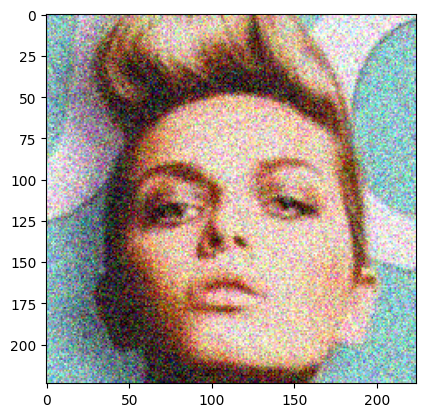

In [59]:
img = trainset[4][0]
img = get_image(img + np.random.randn(*list(img.shape)) * 0.3 )
plt.imshow(img)

In [77]:
class VAE(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size):
        # configurations
        super().__init__()
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num),
        )

        # encoded feature's size and volume
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        # q
        self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
        self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)

        # projection
        self.project = self._linear(z_size, self.feature_volume, relu=False)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),
            self._deconv(kernel_num // 2, kernel_num // 4),
            self._deconv(kernel_num // 4, channel_num),
            nn.Sigmoid()
        )

    def forward(self, x):
        # encode x
        noise_lvl = choice([0.1, 0.2, 0.3])
        if self.training:
            with torch.no_grad():
                x = x + torch.randn(x.shape, device=x.device) * noise_lvl
        encoded = self.encoder(x)

        # sample latent code z from q given x.
        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )

        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)

        # return the parameters of distribution of q given x and the
        # reconstructed image.
        return (mean, logvar), x_reconstructed

    # ==============
    # VAE components
    # ==============

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).cuda() if self._is_on_cuda else
            Variable(torch.randn(std.size()))
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

    # =====
    # Utils
    # =====

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num):
        return nn.Sequential(
            nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num):
        return nn.Sequential(
            nn.ConvTranspose2d(
                channel_num, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

In [84]:
model = VAE("celeba", 224, 3, 128, 240).to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (q_mean): Linear(in_features=100352, out_features=240, bias=True)
  (q_logvar): Linear(in_features=100352, out_features=240, bias=True)
  (project): Linear(in_features=240, out_features=100352, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pa

In [85]:
optimizer = optim.Adam(
        model.parameters(), lr=3e-4,
        weight_decay=1e-5,
    )

In [86]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, validloader)

Train Epoch: 1 [0/162770 (0%)]	Loss: 150030.468750
